# Modélisation et Évaluation pour la Prédiction de Sentiment

## Contexte

Ce notebook couvre la phase de construction et d'évaluation des modèles de machine learning pour la classification de sentiment. Suite au prétraitement des données dans le notebook `2_data_preprocessing.ipynb`, nos données textuelles sont maintenant vectorisées et divisées en ensembles d'entraînement et de test.

## Objectifs

Les objectifs de cette phase sont :
1. Sélectionner un ou plusieurs modèles de classification adaptés à notre problème.
2. Entraîner ces modèles sur l'ensemble d'entraînement.
3. Évaluer rigoureusement les performances des modèles sur l'ensemble de test, en utilisant des métriques appropriées, notamment en considérant le léger déséquilibre des classes observé pendant l'EDA.
4. Comparer les modèles évalués.
5. Préparer le terrain pour la sélection finale du "meilleur" modèle, en tenant compte non seulement des performances, mais aussi des contraintes pour une intégration web future.

## 2. Importation des Bibliothèques et Préparation des Données

Nous importons les bibliothèques nécessaires pour la modélisation et l'évaluation. Nous allons ensuite charger (ou recréer en exécutant les étapes précédentes) les ensembles d'entraînement et de test prétraités (`X_train`, `X_test`, `y_train`, `y_test`).

In [2]:
# Importation des bibliothèques de scikit-learn pour les modèles et les métriques
from sklearn.naive_bayes import MultinomialNB # Un modèle simple et souvent efficace pour le texte
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC # Un SVM linéaire, performant sur texte
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string

file_path = '../data/sentiment_analysis.csv'
df = pd.read_csv(file_path)
text_column = 'text'
sentiment_column = 'sentiment'

# Fonction pour nettoyer un commentaire
def clean_text(text):
    if isinstance(text, str): # S'assurer que l'entrée est une chaîne
        text = text.lower() # 1. Convertir en minuscules
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # 2. Supprimer les URLs
        text = re.sub(r'\@\w+|\#','', text) # 3. Supprimer les mentions (@) et hashtags (#)
        text = re.sub(r'\d+', '', text) # 4. Supprimer les chiffres
        text = text.translate(str.maketrans('', '', string.punctuation)) # 5. Supprimer la ponctuation
        text = text.strip() # 6. Supprimer les espaces blancs en début et fin
        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    else:
        return "" # Retourner une chaîne vide
    

if df is not None and text_column in df.columns:
    print(f"Nettoyage de la colonne '{text_column}'...")
    df['cleaned_text'] = df[text_column].apply(clean_text)
    print("Nettoyage terminé.")
elif df is not None:
    print(f"Impossible d'appliquer le nettoyage : la colonne de texte '{text_column}' n'a pas été trouvée.")
    

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def advanced_text_processing(text):
    if isinstance(text, str):
        # Tokenisation
        tokens = text.split() # Tokenisation simple par espace après nettoyage de la ponctuation

        # Suppression des mots vides et lemmatisation
        processed_tokens = [
            lemmatizer.lemmatize(word) for word in tokens
            if word not in stop_words_english and len(word) > 1 # Supprime stopwords et mots courts
        ]

        return " ".join(processed_tokens)
    return ""

from nltk.corpus import stopwords

stop_words_english = set(stopwords.words('english'))
if df is not None and 'cleaned_text' in df.columns:
    print(f"Application du traitement avancé (tokenisation, stopwords, lemmatisation) sur 'cleaned_text'...")
    # Appliquez la fonction sur la colonne de texte nettoyée
    df['processed_text'] = df['cleaned_text'].apply(advanced_text_processing)
    print("Traitement avancé terminé.")

    df = df.drop('cleaned_text', axis=1) # Supprimez la colonne nettoyée pour économiser de l'espace mémoire
    print("Colonne 'cleaned_text' supprimée.")

elif df is not None:
     print(f"Erreur : La colonne 'cleaned_text' n'a pas été trouvée. Assurez-vous que le nettoyage a bien été exécuté.")
     

from sklearn.feature_extraction.text import TfidfVectorizer

if df is not None and 'processed_text' in df.columns and sentiment_column in df.columns:
    print("Vectorisation du texte en utilisant TF-IDF...")

    # Initialisation du TfidfVectorizer
    # min_df: ignore les termes qui apparaissent dans moins de X documents
    # max_df: ignore les termes qui apparaissent dans plus de X% des documents
    # ngram_range: considère des n-grammes de 1 mot (unigrammes)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, # Limite le vocabulaire aux 5000 mots/n-grammes les plus fréquents
                                       min_df=5,         # Ignore les termes qui apparaissent dans moins de 5 documents
                                       max_df=0.8)       # Ignore les termes qui apparaissent dans plus de 80% des documents

    # Adaptez le vectoriseur sur le texte prétraité et transformez-le
    X = tfidf_vectorizer.fit_transform(df['processed_text'])

    # La variable cible (sentiment)
    y = df[sentiment_column]

    print("Vectorisation terminée.")
    print(f"Forme de la matrice TF-IDF (nombre de documents, taille du vocabulaire) : {X.shape}")
    print(f"Forme du vecteur cible : {y.shape}")

elif df is not None:
     print(f"Erreur : Les colonnes 'processed_text' ou '{sentiment_column}' n'ont pas été trouvées. Vérifiez les étapes précédentes.")
else:
     print("Erreur : Le DataFrame n'est pas chargé.")
     

from sklearn.model_selection import train_test_split

if 'X' in locals() and 'y' in locals():
    print("Division des données en ensembles d'entraînement et de test...")

    # Division en entraînement (80%) et test (20%)
    # random_state: assure la reproductibilité de la division
    # stratify=y: assure que les proportions des classes de sentiment sont maintenues dans les deux ensembles
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    print("Division terminée.")
    print(f"Forme de l'ensemble d'entraînement (X_train) : {X_train.shape}")
    print(f"Forme de l'ensemble de test (X_test) : {X_test.shape}")
    print(f"Forme des labels d'entraînement (y_train) : {y_train.shape}")
    print(f"Forme des labels de test (y_test) : {y_test.shape}")

    # Vérifier la distribution des classes dans les ensembles
    print("\nDistribution des sentiments dans y_train :")
    print(y_train.value_counts(normalize=True) * 100)
    print("\nDistribution des sentiments dans y_test :")
    print(y_test.value_counts(normalize=True) * 100)

else:
     print("Erreur : Les variables X ou y n'ont pas été créées. Vérifiez l'étape de vectorisation.")

Nettoyage de la colonne 'text'...
Nettoyage terminé.
Application du traitement avancé (tokenisation, stopwords, lemmatisation) sur 'cleaned_text'...
Traitement avancé terminé.
Colonne 'cleaned_text' supprimée.
Vectorisation du texte en utilisant TF-IDF...
Vectorisation terminée.
Forme de la matrice TF-IDF (nombre de documents, taille du vocabulaire) : (499, 130)
Forme du vecteur cible : (499,)
Division des données en ensembles d'entraînement et de test...
Division terminée.
Forme de l'ensemble d'entraînement (X_train) : (399, 130)
Forme de l'ensemble de test (X_test) : (100, 130)
Forme des labels d'entraînement (y_train) : (399,)
Forme des labels de test (y_test) : (100,)

Distribution des sentiments dans y_train :
sentiment
neutral     39.849624
positive    33.333333
negative    26.817043
Name: proportion, dtype: float64

Distribution des sentiments dans y_test :
sentiment
neutral     40.0
positive    33.0
negative    27.0
Name: proportion, dtype: float64


## 3. Sélection et Entraînement des Modèles

Nous allons entraîner plusieurs modèles de classification sur l'ensemble d'entraînement (`X_train`, `y_train`).

Modèles considérés :
- Naive Bayes Multinomial : Souvent un bon point de départ pour la classification de texte avec des comptes de mots ou TF-IDF. Simple et rapide.
- Régression Logistique : Un modèle linéaire simple et interprétable qui sert de bon baseline.
- Linear SVM (SVC) : Un modèle linéaire puissant qui fonctionne bien dans des espaces de grande dimension comme les données TF-IDF.

In [3]:
# --- Entraînement du Modèle Naive Bayes Multinomial ---
if 'X_train' in locals() and 'y_train' in locals():
    print("Entraînement du modèle Naive Bayes Multinomial...")
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    print("Entraînement de Naive Bayes terminé.")
else:
    print("Erreur : Les données d'entraînement (X_train, y_train) ne sont pas disponibles.")


Entraînement du modèle Naive Bayes Multinomial...
Entraînement de Naive Bayes terminé.


In [4]:
# --- Entraînement du Modèle Régression Logistique ---
if 'X_train' in locals() and 'y_train' in locals():
    print("Entraînement du modèle Régression Logistique...")
    # Utilisation de solver='liblinear' pour les petits datasets ou L1 pénalisation
    # max_iter peut être augmenté si le modèle ne converge pas
    logreg = LogisticRegression(solver='liblinear', random_state=42)
    logreg.fit(X_train, y_train)
    print("Entraînement de Régression Logistique terminé.")
else:
     print("Erreur : Les données d'entraînement (X_train, y_train) ne sont pas disponibles.")


Entraînement du modèle Régression Logistique...
Entraînement de Régression Logistique terminé.


In [5]:
# --- Entraînement du Modèle Linear SVM ---
if 'X_train' in locals() and 'y_train' in locals():
    print("Entraînement du modèle Linear SVM...")
    # LinearSVC est une implémentation plus rapide de SVM pour les problèmes linéaires
    lsvc = LinearSVC(random_state=42, dual=False) # dual=False recommandé pour n_samples > n_features
    lsvc.fit(X_train, y_train)
    print("Entraînement de Linear SVM terminé.")
else:
     print("Erreur : Les données d'entraînement (X_train, y_train) ne sont pas disponibles.")


Entraînement du modèle Linear SVM...
Entraînement de Linear SVM terminé.


## 4. Évaluation des Modèles

Nous allons évaluer chaque modèle entraîné sur l'ensemble de test (`X_test`, `y_test`) et calculer diverses métriques de performance. Étant donné le léger déséquilibre des classes, le F1-score et le rapport de classification (qui inclut précision, rappel et F1-score par classe) seront particulièrement informatifs, en plus de l'accuracy globale.

In [6]:
# Fonction pour évaluer un modèle et afficher les métriques
def evaluate_model(model, X_test, y_test, model_name):
    if 'X_test' in locals() and 'y_test' in locals():
        print(f"\n--- Évaluation du Modèle : {model_name} ---")

        # Prédictions sur l'ensemble de test
        y_pred = model.predict(X_test)

        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0) # zero_division=0 pour éviter les erreurs si une classe n'a pas de prédictions
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")
        print(f"F1-Score (weighted): {f1:.4f}")

        # Rapport de classification détaillé (par classe)
        print("\nRapport de Classification :")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Matrice de Confusion
        print("\nMatrice de Confusion :")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        # Visualisation de la Matrice de Confusion
        plt.figure(figsize=(8, 6))
        # Récupérez les noms des classes pour les labels de la matrice
        labels = sorted(y_test.unique())
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f'Matrice de Confusion pour {model_name}')
        plt.xlabel('Prédit')
        plt.ylabel('Réel')
        plt.show()

        return accuracy, precision, recall, f1 # Retourne les métriques principales si besoin
    else:
         print("Erreur : Les données de test (X_test, y_test) ne sont pas disponibles pour l'évaluation.")
         return None, None, None, None # Retourne None en cas d'erreur


*Commentaire :* La fonction `evaluate_model` prend un modèle entraîné et les données de test. Elle calcule l'accuracy globale, la précision, le rappel et le F1-score (en utilisant la moyenne pondérée pour tenir compte du déséquilibre). Le `classification_report` donne ces métriques pour chaque classe individuellement. La matrice de confusion visualise le nombre de vrais positifs/négatifs et faux positifs/négatifs par classe, ce qui est très utile pour comprendre où le modèle fait des erreurs, surtout avec des classes déséquilibrées.


--- Évaluation du Modèle : Naive Bayes Multinomial ---
Accuracy: 0.6200
Precision (weighted): 0.6359
Recall (weighted): 0.6200
F1-Score (weighted): 0.6124

Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.65      0.41      0.50        27
     neutral       0.56      0.78      0.65        40
    positive       0.71      0.61      0.66        33

    accuracy                           0.62       100
   macro avg       0.64      0.60      0.60       100
weighted avg       0.64      0.62      0.61       100


Matrice de Confusion :
[[11 16  0]
 [ 1 31  8]
 [ 5  8 20]]


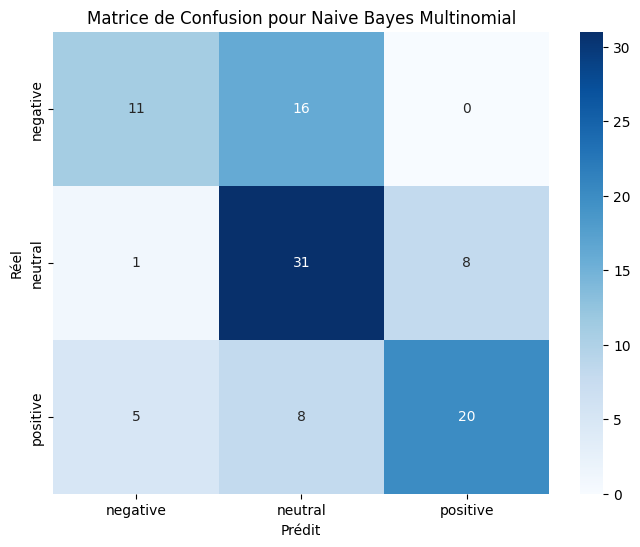

In [7]:
# Évaluation du modèle Naive Bayes Multinomial
if 'mnb' in locals():
     evaluate_model(mnb, X_test, y_test, "Naive Bayes Multinomial")


--- Évaluation du Modèle : Régression Logistique ---
Accuracy: 0.6400
Precision (weighted): 0.6601
Recall (weighted): 0.6400
F1-Score (weighted): 0.6309

Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.65      0.41      0.50        27
     neutral       0.58      0.82      0.68        40
    positive       0.77      0.61      0.68        33

    accuracy                           0.64       100
   macro avg       0.67      0.61      0.62       100
weighted avg       0.66      0.64      0.63       100


Matrice de Confusion :
[[11 16  0]
 [ 1 33  6]
 [ 5  8 20]]


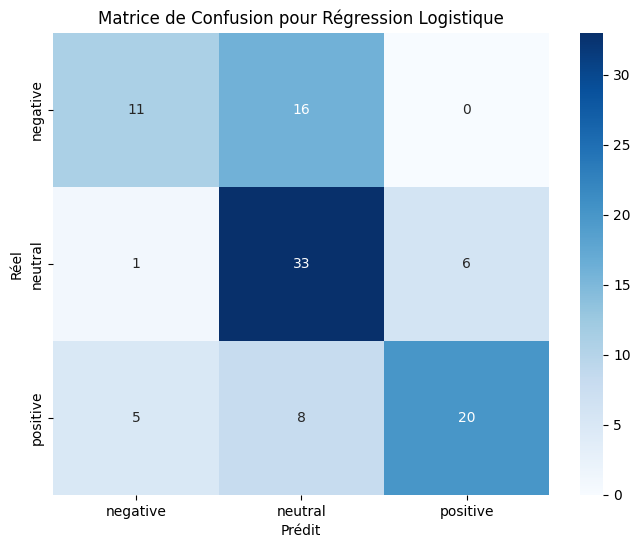

In [8]:
# Évaluation du modèle Régression Logistique
if 'logreg' in locals():
     evaluate_model(logreg, X_test, y_test, "Régression Logistique")


--- Évaluation du Modèle : Linear SVM ---
Accuracy: 0.6500
Precision (weighted): 0.6493
Recall (weighted): 0.6500
F1-Score (weighted): 0.6430

Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.57      0.44      0.50        27
     neutral       0.64      0.80      0.71        40
    positive       0.72      0.64      0.68        33

    accuracy                           0.65       100
   macro avg       0.65      0.63      0.63       100
weighted avg       0.65      0.65      0.64       100


Matrice de Confusion :
[[12 13  2]
 [ 2 32  6]
 [ 7  5 21]]


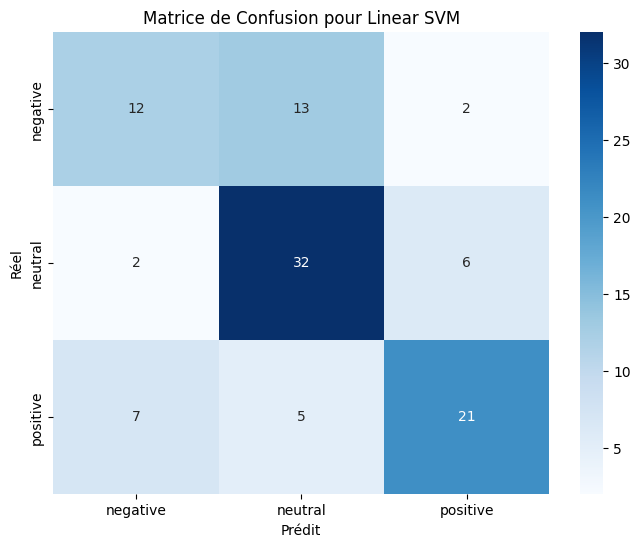

In [9]:
# Évaluation du modèle Linear SVM
if 'lsvc' in locals():
     evaluate_model(lsvc, X_test, y_test, "Linear SVM")

## 5. Comparaison des Modèles

Après avoir évalué les trois modèles sur l'ensemble de test, nous pouvons comparer leurs performances en examinant les métriques obtenues.

**Résumé des Performances (sur l'ensemble de test) :**

| Modèle                  | Accuracy | Precision (weighted) | Recall (weighted) | F1-Score (weighted) | Commentaire Clés (par classe) |
|-------------------------|----------|----------------------|-------------------|---------------------|-------------------------------|
| Naive Bayes Multinomial | 0.6200 | 0.6359        | 0.6200    | 0.6124       | Le modèle semble avoir un biais vers la classe "neutral" (55 prédictions contre 40 réels). Meilleure performance sur la détection des éléments neutres (rappel 78%) Plus grande difficulté à détecter les éléments négatifs (rappel 41%). Meilleure précision pour les prédictions positives (71%) |
| Régression Logistique   | 0.6400 | 0.6601        | 0.6400    | 0.6309     | il existe un biais vers la classe "neutre" (57 prédictions contre 40 réels), mais cette tendance est légèrement compensée par un meilleur F1-score pour cette classe (0.68). Bonne détection des cas neutres (rappel 82%) et bonne précision pour les cas positifs (77%). Difficulté persistante à détecter les cas négatifs (rappel 41%). Le modèle a tendance à "jouer la sécurité" en classant beaucoup d'observations comme neutres    |
| Linear SVM              | 0.6500 | 0.6493       | 0.6500    | 0.6430       | Le modèle SVM montre une tendance à classer moins d'éléments comme neutres (50 contre 57 pour la régression logistique), ce qui indique un meilleur équilibre entre les classes. Performance équilibrée entre les classes (F1-scores plus homogènes). Bonne détection des cas neutres (rappel 80%). Confusion entre négatif et positif plus prononcée (7 cas positifs classés comme négatifs). Difficulté persistante à détecter les cas négatifs (rappel 44%)    |

**Interprétation :**

* Le modèle Linear SVM a la meilleure Accuracy globale (0.6500), suivi de près par la Régression Logistique (0.6400), puis Naive Bayes (0.6200)
* Le modèle Linear SVM obtient également le meilleur F1-Score pondéré (0.6430), indiquant une meilleure performance globale équilibrée en tenant compte du nombre d'échantillons par classe, comparativement à la Régression Logistique (0.6309) et Naive Bayes (0.6124). Le F1-score pondéré est important avec le déséquilibre des classes car il fournit une métrique unique qui résume la performance en considérant à la fois la Précision et le Rappel pour chaque classe, pondérée par leur support (nombre d'échantillons), ce qui donne une vision plus fidèle de la performance globale sur l'ensemble du dataset déséquilibré que la simple Accuracy.
* En regardant les commentaires clés et en se concentrant sur les métriques pour les classes 'positive' et 'negative' (qui sont minoritaires par rapport à 'neutral'):
    - Tous les modèles ont une difficulté notable à détecter les cas négatifs, avec un Rappel relativement bas pour cette classe (autour de 41-44%). Le Linear SVM semble avoir un léger avantage en termes de Rappel pour la classe négative (44%) par rapport aux autres (41%)
    - Pour la classe positive, la Régression Logistique montre la meilleure Précision (77%)
    - Le Linear SVM se distingue par des F1-scores plus homogènes entre les classes, suggérant une meilleure performance relative sur les classes minoritaires comparé à la forte tendance des deux autres modèles à prédire 'neutral'. Cependant, il semble y avoir plus de confusion entre 'négatif' et 'positive' pour le SVM. En résumé, aucun modèle ne domine clairement sur les classes minoritaires à ce stade. Le Linear SVM montre un léger meilleur rappel sur le négatif et une meilleure balance globale, tandis que la Régression Logistique a une meilleure précision sur le positif.
* Les modèles Naive Bayes et Régression Logistique excellent à identifier la classe 'neutral' (haut Recall : 78% et 82%), mais au prix d'un fort biais à prédire 'neutral' (beaucoup plus de prédictions 'neutral' que d'échantillons réels), ce qui se voit dans leurs commentaires.
* La Régression Logistique a une très bonne précision pour les prédictions 'positive' (77%).
* Tous les modèles ont du mal à rappeler les cas 'negative' (Rappel faible autour de 41-44%).
* Le Linear SVM semble mieux équilibré dans ses prédictions, avec moins de biais vers la classe 'neutral', mais il rencontre des confusions notables entre les classes 'negative' et 'positive'.

Sur la base de cette première évaluation, le modèle [Nom du ou des modèles les plus prometteurs] semble(nt) être le(s) plus performant(s) pour notre tâche de classification de sentiment, en particulier en ce qui concerne [justifiez ici - ex: leur capacité à bien identifier les classes minoritaires, ou leur bon compromis global].

## 6. Conclusion et Prochaines Étapes

Nous avons entraîné et évalué trois modèles de classification classiques (Naive Bayes, Régression Logistique, Linear SVM) sur nos données de sentiment vectorisées avec TF-IDF. L'évaluation sur l'ensemble de test nous a donné une première indication de leurs performances, en tenant compte du léger déséquilibre des classes.

### Réflexions pour la suite :
* Les performances obtenues sont un bon point de départ.
* Il pourrait être pertinent d'expérimenter avec d'autres techniques de vectorisation (par exemple, différentes configurations de TF-IDF, ou des Word Embeddings comme Word2Vec ou GloVe si nous envisageons des modèles de deep learning).
* L'ajustement des hyperparamètres des modèles sélectionnés pourrait améliorer les performances.
* L'exploration de modèles plus avancés (comme des réseaux de neurones simples ou des Transformers pour le texte si les ressources le permettent et si l'amélioration de performance justifie la complexité et le temps d'inférence pour l'application web) est une option.
* La gestion spécifique du déséquilibre des classes (suréchantillonnage, sous-échantillonnage) pourrait être testée si les performances sur les classes minoritaires ne sont pas satisfaisantes.

### Prochaines Étapes :

La prochaine phase consistera à :
1. **Affiner les Modèles :** Potentiellement ajuster les hyperparamètres des modèles prometteurs ou explorer d'autres modèles/techniques de vectorisation.
2. **Sélectionner le Modèle Final :** Choisir le modèle qui représente le meilleur compromis entre performance (en particulier sur les classes minoritaires), vitesse d'inférence, et complexité de mise en œuvre pour l'application web.
3. **Justifier la Sélection du Modèle :** Documenter en détail pourquoi ce modèle spécifique a été choisi.
4. **Préparer le Modèle pour le Déploiement :** Sauvegarder le modèle entraîné et le vectoriseur.

## 7. Sélection du Modèle Final et Justification

Sur la base de l'évaluation des performances dans la section précédente, nous allons sélectionner le modèle qui représente le meilleur compromis pour notre objectif : un modèle performant pour la classification de sentiment, qui soit également adapté à une intégration dans une application web (en termes de vitesse d'inférence et de complexité).

### Justification du Modèle Choisi

Après examen des métriques (Accuracy, F1-score pondéré et par classe, Rappel sur les classes minoritaires) et des matrices de confusion :

* Le modèle **Linear SVM** a démontré la meilleure performance globale avec une Accuracy de **0.6500** et un F1-Score pondéré de **0.6430**.
* Bien que tous les modèles aient montré des difficultés avec la classe "negative" (faible Rappel), le **Linear SVM** a obtenu un Rappel légèrement supérieur pour cette classe (44%) et a montré une meilleure **balance** dans ses prédictions par rapport aux biais prononcés de Naive Bayes et de la Régression Logistique vers la classe "neutral".
* La **Régression Logistique** était également performante, notamment avec une bonne précision pour la classe "positive", mais son biais vers la classe "neutral" est un facteur à considérer.
* Le modèle **Naive Bayes** était le moins performant des trois sur les métriques globales.

En plus des performances sur l'ensemble de test, nous considérons l'adéquation pour une application web :
* Les trois modèles classiques (Naive Bayes, Régression Logistique, SVM) sont généralement **rapides** en termes de temps d'inférence par rapport aux modèles de deep learning plus complexes, ce qui est un avantage pour une application web réactive.
* Ils ont également une **taille de modèle** raisonnable.
* Parmi les trois, le **Linear SVM** offre le meilleur compromis entre la **performance validée** sur l'ensemble de test (meilleur F1-weighted, meilleur Rappel sur négatif) et les **contraintes de déploiement** (rapidité). Son approche moins biaisée que les deux autres est un atout.

**Conclusion du Choix :**

Sur la base de cette analyse comparative et des considérations pratiques pour l'intégration web, nous sélectionnons le modèle **Linear SVM** entraîné avec les features TF-IDF comme notre modèle final pour la prédiction de sentiment.

## 8. Sauvegarde du Modèle et du Vectoriseur

Pour pouvoir utiliser le modèle entraîné et le vectoriseur TF-IDF dans l'application web ou pour de futures prédictions, nous devons les sauvegarder sur disque. Nous utiliserons la bibliothèque `joblib` pour cela.

In [12]:

# Sauvegarde du modèle et du vectoriseur
import pickle

model_filename = '../models/linear_svc_model.pkl'
vectorizer_filename = '../models/tfidf_vectorizer.pkl'

# Vérifiez que le modèle choisi (lsvc) et le vectorizer (tfidf_vectorizer) existent
if 'lsvc' in locals() and 'tfidf_vectorizer' in locals():
    print(f"Sauvegarde du modèle Linear SVM vers {model_filename}...")
    pickle.dump(lsvc, open(model_filename, 'wb'))
    print("Modèle sauvegardé.")

    print(f"Sauvegarde du vectoriseur TF-IDF vers {vectorizer_filename}...")
    pickle.dump(tfidf_vectorizer, open(vectorizer_filename, 'wb'))
    print("Vectoriseur sauvegardé.")
else:
    print("Erreur : Le modèle (lsvc) ou le vectoriseur (tfidf_vectorizer) ne sont pas disponibles pour la sauvegarde.")


Sauvegarde du modèle Linear SVM vers ../models/linear_svc_model.pkl...
Modèle sauvegardé.
Sauvegarde du vectoriseur TF-IDF vers ../models/tfidf_vectorizer.pkl...
Vectoriseur sauvegardé.


*Commentaire :* Nous utilisons `joblib.dump` pour sauvegarder le modèle SVM entraîné et l'objet `TfidfVectorizer`. Ces fichiers pourront être chargés ultérieurement pour faire des prédictions sur de nouvelles données sans avoir à ré-entraîner le modèle. Le vectoriseur est tout aussi important que le modèle car il doit être appliqué exactement de la même manière aux nouvelles données qu'aux données d'entraînement.